The last blog post was about digit recognition, this time we try to generate some ourselves, for this purpose GANs, generative adversarial networks, are suitable. There are other possible types of AI for image generation, for example variational autoencoders (VAEs) or PixelCNN, but GANs are popular, so there are plenty of resources and tools available.

The basic idea of GANs is to have two neural networks, a generator and a discriminator, that compete against each other. The generator tries to generate images that are as similar as possible to the training data, while the discriminator tries to distinguish between real and fake images. The generator is trained to fool the discriminator, while the discriminator is trained to not be fooled by the generator.

So as a beginner the idea of two networks competing is really interesting and learning GANs opens the door to many advanced applications beyond digit generation like image-to-image translation (e.g. photos into paintings), image-sharpening, art generation and much more.

So starting with the code, the first new thing is the normalization. As the models we use get more complex, normalization is recommended and generally makes the training more stable, so we will use it from now on. By scaling input values to a small range (in this case, between -1 and 1), it ensures that no particular feature dominates the training due to its scale. This can help the optimizer converge faster.

*transforms.ToTensor()* converts the image from a PIL format (which is how the images are loaded by default) into a PyTorch tensor.
transforms. Normalize((0.5,), (0.5,)) normalizes the image tensor. The first tuple, (0.5,), is the mean, and the second tuple, (0.5,), is the standard deviation. 

For greyscale images like MNIST, the mean and standard deviation are provided as single values. For RGB images, they would be provided as three values, e.g., (0.5, 0.5, 0.5).

Specifically for GANs there are some additional advantages using normalization: The interplay of the two networks, where the output from network serves as the input for the other network can lead to unstable training dynamics if the data isn't normalized. Also we will use the tanh activation function on the generator's output layer, which outputs values in the range of [-1, 1]. By normalizing the real data to this range, we ensure that the generated data and real data are in the same value range. This consistency makes the discriminator's task of distinguishing real from fake more about the content and style of the images rather than arbitrary scale differences.


In [2]:
import torch
from torchvision import transforms

# Check if CUDA is available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformation (Normalization)
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

Additionally, I found out that you can download various datasets directly via PyTorch (and also Tensorflow), which makes my previous more cumbersome method obsolete and now we can download everything with one line.

In [3]:
from torchvision import datasets

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

This time we'll take a larger batch size than last time, since I have a relatively good GPU (RTX 2070 Super with 8 GB). 128 is a common choice and it is again a power of 2 (It was also recommende in the original DCGAN Paper by Radford et. al -  	
https://doi.org/10.48550/arXiv.1511.06434). Using powers of 2 for batch size is a common practice due to how memory is allocated and accessed in computers.

In [4]:
from torch.utils.data import DataLoader

# Create DataLoader for training data
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

For the structure of the GAN we first take a typical feed-forward network to produce a first prediction. for the false images we need a "random noise vector" which we initiate with a size of 100. The noise vector serves as a seed or starting point for generation. The generator's job is to expand (which we do step-wise with the sequential fully-connected layers) and transform this seed into a meaningful image representation. The latent space (of size z_dim) is typically much smaller than the image space to ensure that the generator learns a compact representation of the data. This compactness forces the generator to capture the most significant variations in the dataset.

In [5]:
import torch.nn as nn

# Generator network
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_dim=784):
        super(Generator, self).__init__()

        # Fully Connected Layers
        self.linear1 = nn.Linear(z_dim, 128)
        self.linear2 = nn.Linear(128, 256)
        self.linear3 = nn.Linear(256, 512)
        self.linear4 = nn.Linear(512, img_dim)
        
        # Activation functions
        self.leaky_relu = nn.LeakyReLU(0.01)
        self.tanh = nn.Tanh() # To bring the generated values between [-1, 1] as we normalized our images to this range
        
    def forward(self, x): 
        x = self.leaky_relu(self.linear1(x))
        x = self.leaky_relu(self.linear2(x))
        x = self.leaky_relu(self.linear3(x))
        x = self.tanh(self.linear4(x))
        
        return x
        

In contrast to the generator the discriminator is built exactly the other way around. Here the layers get consequently smaller until we end up with a value between 0 and 1 by the sigmoid function, which represents the probability that the input image is real.

In [6]:
# Define the Discriminator network
class Discriminator(nn.Module):
    def __init__(self, img_dim=784):
        super(Discriminator, self).__init__()
        
        # Fully Connected Layers
        self.linear1 = nn.Linear(img_dim, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 128)
        self.linear4 = nn.Linear(128, 1)
        
        # Activation functions
        self.leaky_relu = nn.LeakyReLU(0.01)
        self.sigmoid = nn.Sigmoid() # To bring the output values between [0, 1] indicating the probability of being real
        
    def forward(self, x):
        x = self.leaky_relu(self.linear1(x))
        x = self.leaky_relu(self.linear2(x))
        x = self.leaky_relu(self.linear3(x))
        x = self.sigmoid(self.linear4(x))
        
        return x

Now we push the models to the GPU. For the loss we use the Binary Cross Entropy Loss, as the discriminator is essentially a binary classifier (real vs. fake), so this loss function is suitable for our case. It computes the cross-entropy between the predicted probabilities and the true labels. The specific choice of 0.0002 is a common default for GANs (see Radford et. al).
We also use label smoothing, so instead of using hard labels of 1 for real images and 0 for fake, label smoothing uses slightly different values. **real_labels = 0.9** means real images will have a label of 0.9 instead of 1. This technique can make the discriminator's job slightly harder, preventing it from becoming too confident and aiding in stabilizing GAN training.

In [7]:
import torch.optim as optim

# Instantiate the Generator and Discriminator networks
gen = Generator().to(device)
disc = Discriminator().to(device)

# Define the loss and optimizers
criterion = nn.BCELoss()

lr = 0.0002
gen_optimizer = optim.Adam(gen.parameters(), lr=lr)
disc_optimizer = optim.Adam(disc.parameters(), lr=lr)

# Number of epochs
n_epochs = 50
# Length of the latent vector (Random noise)
z_dim = 100
# Label smoothing
real_labels = 0.9
fake_labels = 0

Now let's break down the training loop: The fist part is the training of the discriminator. *real_data* contains the actual images from the MNIST dataset, and *_* represents the true labels, which are ignored here since GANs are unsupervised. The discriminator is passed real images, and it outputs a probability score indicating if each image is real or fake. The loss is calculated by comparing the discriminator's predictions (*real_preds*) with the true labels (which are close to 1 due to label smoothing). Then we generate the random noise vector and pass it through the generator to produce fake images and let the discriminator classify them. The loss is calculated by comparing the discriminator's predictions with the true labels for fake images (which are 0). The total loss for the discriminator is the sum of the loss for real and fake images.
The next part is the training of the generator. Again, fake images are generated using the generator, though when computing the loss for the generator, the aim is to "fool" the discriminator. Hence, the target labels are ones (indicating real images). If the discriminator believes the fake images are real, the generator is doing a good job 

In [8]:
# Start training
for epoch in range(n_epochs):
    for batch_idx, (real_data, _) in enumerate(train_loader):
        real_data = real_data.view(-1, 784).to(device)  # Flatten the image
        batch_size = real_data.shape[0]

        ### Train the Discriminator ###
        disc_optimizer.zero_grad()

        # Compute loss on real data
        real_preds = disc(real_data)
        real_loss = criterion(real_preds, torch.ones(batch_size, 1).to(device) * real_labels)

        # Generate fake data
        noise = torch.randn(batch_size, z_dim).to(device)
        fake_data = gen(noise)

        # Compute loss on fake data
        fake_preds = disc(fake_data.detach())
        fake_loss = criterion(fake_preds, torch.zeros(batch_size, 1).to(device) * fake_labels)

        # Combine losses and update Discriminator
        disc_loss = real_loss + fake_loss
        disc_loss.backward()
        disc_optimizer.step()

        ### Train the Generator ###
        gen_optimizer.zero_grad()

        # Generate fake data
        noise = torch.randn(batch_size, z_dim).to(device)
        fake_data = gen(noise)

        # Compute loss on fake data with inverted labels
        fake_preds = disc(fake_data)
        gen_loss = criterion(fake_preds, torch.ones(batch_size, 1).to(device))

        # Update Generator
        gen_loss.backward()
        gen_optimizer.step()
 
    print(f"Epoch [{epoch + 1}/{n_epochs}] Loss D: {disc_loss.item()}, Loss G: {gen_loss.item()}")

Epoch [1/50] Loss D: 0.642920196056366, Loss G: 2.6018149852752686
Epoch [2/50] Loss D: 0.49951082468032837, Loss G: 2.7322940826416016
Epoch [3/50] Loss D: 0.4253237247467041, Loss G: 4.336671352386475
Epoch [4/50] Loss D: 0.49214255809783936, Loss G: 3.488773822784424
Epoch [5/50] Loss D: 0.44492125511169434, Loss G: 3.247403621673584
Epoch [6/50] Loss D: 0.4901518225669861, Loss G: 8.406545639038086
Epoch [7/50] Loss D: 0.42955657839775085, Loss G: 3.5317835807800293
Epoch [8/50] Loss D: 0.3431251049041748, Loss G: 9.27466106414795
Epoch [9/50] Loss D: 0.3978242874145508, Loss G: 4.168121337890625
Epoch [10/50] Loss D: 0.46336668729782104, Loss G: 5.9529242515563965
Epoch [11/50] Loss D: 0.45307400822639465, Loss G: 4.722975730895996
Epoch [12/50] Loss D: 0.46993932127952576, Loss G: 3.670745372772217
Epoch [13/50] Loss D: 0.40898290276527405, Loss G: 7.936224937438965
Epoch [14/50] Loss D: 0.5095274448394775, Loss G: 6.976125240325928
Epoch [15/50] Loss D: 0.5968165397644043, Loss 

Now let's see some of the resulting images.

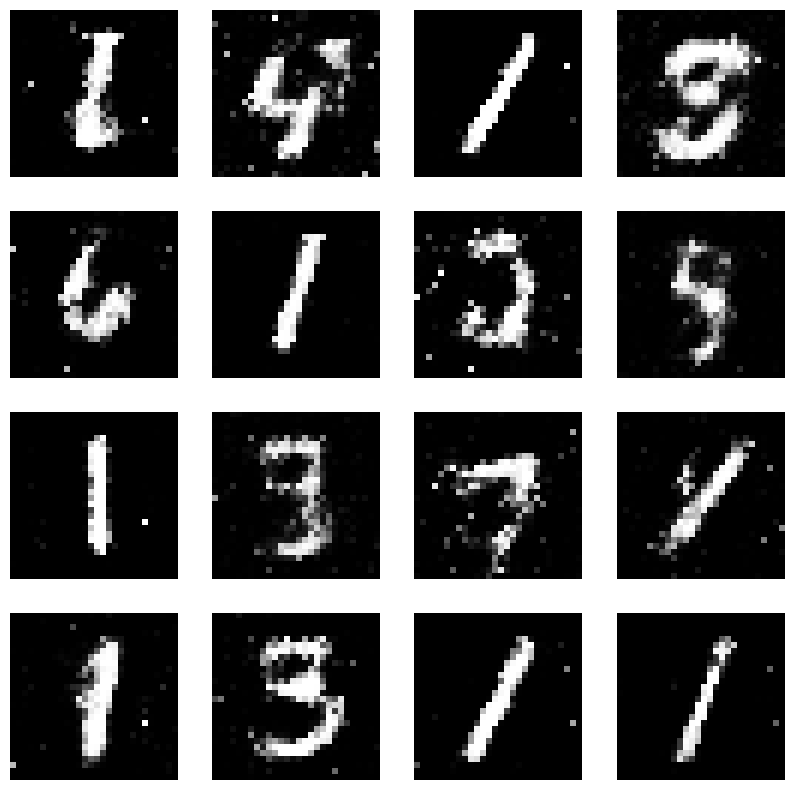

In [9]:
import matplotlib.pyplot as plt

# Generate some samples to evaluate
with torch.no_grad():
    noise = torch.randn(16, z_dim).to(device)
    generated_data = gen(noise).view(-1, 28, 28).cpu().numpy()

# Visualize the generated samples
plt.figure(figsize=(10, 10))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_data[i], cmap='gray')
    plt.axis('off')

plt.show()

This worked relatively well, I can recognize ones, threes, a four and a six. I would say a very good result for such a basic network!